In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import japanize_matplotlib
from pathlib import Path

# 現在のノートブックからの相対パスを絶対パスに変換
notebook_dir = Path(os.path.abspath('')).parent
data_path = notebook_dir / 'data' / 'processed' / 'wt262avs.adicht_rec2.parquet'

# データの読み込み
df = pd.read_parquet(data_path)

# データの先頭を表示
print("DataFrameの先頭5行:")
display(df.head())

# データの基本情報を表示
print("\nDataFrameの基本情報:")
display(df.info())

DataFrameの先頭5行:


,PFC,PPC,A1,V1,Stimulus,Time_s,PFC_filtered,PPC_filtered,A1_filtered,V1_filtered,Event_ID,Stimulus_Type
0,63.68750,-48.06250,-76.906250,-55.328125,-0.000312,0.000,-9.687126,-29.744644,-29.668319,-31.102712,0,No_Stimulus
1,42.40625,-50.87500,-80.546875,-57.750000,-0.000312,0.001,-16.177164,-31.208505,-31.960842,-31.552850,0,No_Stimulus
2,31.43750,-70.71875,-99.937500,-82.546875,-0.000312,0.002,-22.393838,-32.559073,-34.101970,-31.901094,0,No_Stimulus
3,30.37500,-44.06250,-70.140625,-49.937500,-0.000312,0.003,-28.047092,-33.677845,-35.946312,-32.045870,0,No_Stimulus
4,-4.53125,-58.40625,-88.937500,-58.468750,0.000000,0.004,-32.896286,-34.466580,-37.366260,-31.903339,0,No_Stimulus



DataFrameの基本情報:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240450 entries, 0 to 4240449
Data columns (total 12 columns):
 #   Column         Dtype  
---  ------         -----  
 0   PFC            float32
 1   PPC            float32
 2   A1             float32
 3   V1             float32
 4   Stimulus       float32
 5   Time_s         float64
 6   PFC_filtered   float64
 7   PPC_filtered   float64
 8   A1_filtered    float64
 9   V1_filtered    float64
 10  Event_ID       int64  
 11  Stimulus_Type  object 
dtypes: float32(5), float64(5), int64(1), object(1)
memory usage: 307.3+ MB


None

In [4]:
# Stimulus_TypeごとのEvent_IDのユニークな数を計算
unique_event_counts = df.groupby('Stimulus_Type')['Event_ID'].nunique()

# 結果を表示
print("Stimulus_TypeごとのEvent_IDのユニークな数:")
display(unique_event_counts)

Stimulus_TypeごとのEvent_IDのユニークな数:


Stimulus_Type
Light          600
Light+Sound    600
No_Stimulus      2
Sound          600
Name: Event_ID, dtype: int64

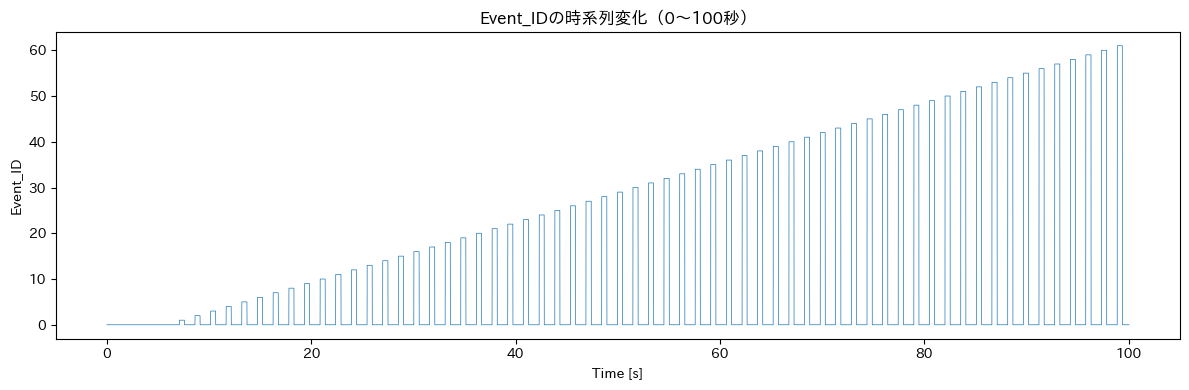

In [5]:
# 0～100秒のデータを抽出
df_0_100s = df[(df['Time_s'] >= 0) & (df['Time_s'] <= 100)]

# Event_IDの時系列変化をプロット
plt.figure(figsize=(12, 4))
plt.plot(df_0_100s['Time_s'], df_0_100s['Event_ID'], lw=0.5)
plt.xlabel('Time [s]')
plt.ylabel('Event_ID')
plt.title('Event_IDの時系列変化（0～100秒）')
plt.tight_layout()
plt.show()

In [7]:
import pandas as pd
import numpy as np
import mne

# --- データの準備 ---
# ここにお手元のDataFrameをロードしてください
# 例: df = pd.read_csv('your_data.csv') 

# MNEで扱うための基本情報を設定
sfreq = 1000  # サンプリング周波数 (1000Hz)
ch_names = ['PFC', 'PPC', 'A1', 'V1'] # チャンネル名
ch_types = ['eeg'] * len(ch_names) # チャンネルタイプは全て'eeg'

# MNEのInfoオブジェクトを作成
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

# 使用するデータを選択 (フィルタリング済みの列)
eeg_data = df[['PFC_filtered', 'PPC_filtered', 'A1_filtered', 'V1_filtered']].T

# MNEのRawオブジェクトを作成 (データはボルト単位にするため 1e-6 をかける)
# 元データがµVの場合を想定
raw = mne.io.RawArray(eeg_data.values * 1e-6, info)

print("MNE Rawオブジェクトが作成されました。")
print(raw)

Creating RawArray with float64 data, n_channels=4, n_times=4240450
    Range : 0 ... 4240449 =      0.000 ...  4240.449 secs
Ready.
MNE Rawオブジェクトが作成されました。
<RawArray | 4 x 4240450 (4240.4 s), ~129.4 MiB, data loaded>


In [ ]:
# --- 修正版コード ---
# onsets DataFrameが正しく作成されている前提で開始します
onsets = df[(df['Event_ID'] != 0) & (df['Event_ID'].shift(1) == 0)]

# ステップ1: 新しいシンプルなイベントIDを定義する
# これが最終的にMNEに渡す辞書になります
simple_event_map = {'Light': 1, 'Sound': 2, 'Light+Sound': 3, 'No_Stimulus': 99}

# ステップ2: 元のイベントID（1-1800）から新しいID（1, 2, 3）へ変換する
# まず、どのStimulus_Typeがどの新しいIDに対応するかを紐付けます
type_to_new_id = onsets['Stimulus_Type'].map(simple_event_map)

# 元のイベント配列を作成
event_samples = onsets.index.values
# ここで、Stimulus_Typeに基づいて変換した新しいID（1, 2, 3）をevent_idsとして使用します
event_ids = type_to_new_id.astype(int).values

# 新しいIDで上書きしたイベント配列を作成
events_remapped = np.array([event_samples, np.zeros_like(event_ids), event_ids]).T

print("イベントIDをシンプルな整数に再マッピングしました。")
print("変換後のイベント配列（先頭5件）:")
print(events_remapped[:5])

# ステップ3: 再マッピングしたイベント配列と、シンプルな辞書を使ってEpochsを作成
tmin, tmax = -0.2, 0.5
baseline = (tmin, 0)

# rawオブジェクトは作成済みとします
epochs = mne.Epochs(raw, events_remapped, event_id=simple_event_map, tmin=tmin, tmax=tmax,
                    baseline=baseline, preload=True,
                    on_missing='warn') # 'No_Stimulus' が辞書に含まれていない場合に警告を出す

print("\n--- 正常に作成されたEpochsオブジェクト ---")
print(epochs)
# No_Stimulusを除いた各カテゴリのイベント数が表示される

イベントIDをシンプルな整数に再マッピングしました。
変換後のイベント配列（先頭5件）:
[[ 7086     0     1]
 [ 8618     0     1]
 [10148     0     1]
 [11664     0     1]
 [13197     0     1]]
Not setting metadata
1801 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1801 events and 701 original time points ...
0 bad epochs dropped

--- 正常に作成されたEpochsオブジェクト ---
<Epochs | 1801 events (all good), -0.2 – 0.5 s (baseline -0.2 – 0 s), ~38.5 MiB, data loaded,
 'Light': 600
 'Sound': 600
 'Light+Sound': 600
 'No_Stimulus': 1>


In [23]:
import mne
import matplotlib.pyplot as plt
import numpy as np

# 前のステップで作成した 'epochs' オブジェクトがあると仮定します

# 解析する刺激タイプを定義
stimulus_types = ['Light', 'Sound', 'Light+Sound']

# 結果を保存するための辞書を初期化
ica_objects = {}
cleaned_epochs_dict = {}

# 各刺激タイプについてループ処理
for stim_type in stimulus_types:
    print(f"\n{'='*20} 刺激タイプ: {stim_type} の処理を開始 {'='*20}")
    
    # 該当する刺激タイプのエポックを抽出
    epochs_stim = epochs[stim_type]
    
    # 1. ICAの準備と実行
    # n_componentsはチャンネル数（4）に設定
    ica = mne.preprocessing.ICA(n_components=4, random_state=97, max_iter='auto')
    ica.fit(epochs_stim)
    ica_objects[stim_type] = ica # 後で使えるようにICAオブジェクトを保存
    
    print(f"\n--- {stim_type}: 各IC成分の評価 ---")

    # ▼▼▼ 修正版コード（このブロックに丸ごと差し替え） ▼▼▼

    # 3. 各成分を個別のプロットで可視化
    print(f"'{stim_type}' の各IC成分のプロパティを個別にプロットします。")

    # 3a. コンポーネント時系列の可視化 (生波形)
    # このプロットはICAオブジェクトから直接呼び出せます
    print("IC時系列プロットを表示します...")
    ica.plot_sources(epochs_stim, title=f'IC Time Series ({stim_type})')

    # --- ここから修正箇所 ---
    # 最初にICの活動をEpochsオブジェクトとして取得します
    ic_epochs = ica.get_sources(epochs_stim)
    print("\nICの時系列データ（ソース）を取得しました。これを用いてPSDとERPをプロットします。")
    # ------------------------

    # 3b. パワースペクトルの可視化
    print("ICパワースペクトルプロットを表示します...")
    # 取得したic_epochsからPSDを計算し、プロットします
    # picks='all' を指定して、全てのIC成分を明示的に対象とします
    ic_epochs.compute_psd(fmax=40, picks='all').plot(show=False)
    plt.suptitle(f'IC Power Spectrum ({stim_type})', top=0.95) # タイトルを設定
    plt.show()

    # 3c. ERP波形の可視化
    print("ICのERP波形プロットを表示します...")
    # 同様に、取得したic_epochsを平均してERP波形を描画します
    fig = ic_epochs.average().plot(window_title=f'IC ERP Waveform ({stim_type})', show=False)
    # y軸のラベルを分かりやすく変更
    for ax in fig.get_axes():
        ax.set_ylabel('Activation (a.u.)', rotation=90)
    plt.show()

    # 4. ノイズ成分の特定と除去
    # 上記のプロットを見て、除去したい成分の番号をユーザーが指定します
    # ----- ▼▼▼ ユーザーが手動で編集する箇所 ▼▼▼ -----
    ica.exclude = [] # 例: 心拍や筋電ノイズと思われる成分番号をリストで指定 -> [0, 3]
    # ---------------------------------------------
    
    if ica.exclude:
        print(f"\n>>> {stim_type}: IC {ica.exclude} をノイズ成分として除去します。")
        # ICAを適用してノイズ除去（.copy() を使って元のデータを保護）
        cleaned_epochs = ica.apply(epochs_stim.copy())
        cleaned_epochs_dict[stim_type] = cleaned_epochs
    else:
        print(f"\n>>> {stim_type}: 除去するICは指定されませんでした。")
        # 何も除去しない場合は、元のデータをそのまま格納
        cleaned_epochs_dict[stim_type] = epochs_stim

print(f"\n{'='*20} 全ての処理が完了しました {'='*20}")


==================== 刺激タイプ: Light の処理を開始 ====================
Fitting ICA to data using 4 channels (please be patient, this may take a while)


C:\Users\dmasu\AppData\Local\Temp\ipykernel_24452\746416230.py:24: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(epochs_stim)
C:\Users\dmasu\AppData\Local\Temp\ipykernel_24452\746416230.py:24: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs_stim)


Selecting by number: 4 components
Fitting ICA took 1.0s.

--- Light: 各IC成分の評価 ---
'Light' の各IC成分のプロパティを個別にプロットします。
IC時系列プロットを表示します...
Not setting metadata
600 matching events found
No baseline correction applied
0 projection items activated

ICの時系列データ（ソース）を取得しました。これを用いてPSDとERPをプロットします。
ICパワースペクトルプロットを表示します...
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).


ValueError: picks (NoneNone, treated as "data") yielded no channels, consider passing picks explicitly

In [24]:
from mne.preprocessing import ICA

# 1. ICAモデルの初期化
# n_componentsにデータのランクを指定し、アルゴリズムにfasticaを使用
ica = ICA(n_components=None, # NoneにするとMNEが自動でランクを推定します
          method='fastica',
          random_state=97,  # 結果を再現可能にするための乱数シード
          max_iter='auto')

# 2. epochsデータ全体でICAモデルを学習（フィット）
# ノンEEGチャネル（例えばEOGなど）があれば除外するために picks='eeg' を指定
ica.fit(epochs, picks='eeg')

print("--- ICAモデルの学習が完了しました ---")
print(ica)

Fitting ICA to data using 4 channels (please be patient, this may take a while)


C:\Users\dmasu\AppData\Local\Temp\ipykernel_24452\4196922409.py:12: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(epochs, picks='eeg')
C:\Users\dmasu\AppData\Local\Temp\ipykernel_24452\4196922409.py:12: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs, picks='eeg')


Selecting by non-zero PCA components: 4 components
Fitting ICA took 6.0s.
--- ICAモデルの学習が完了しました ---
<ICA | epochs decomposition, method: fastica (fit in 10 iterations on 1262501 samples), 4 ICA components (4 PCA components available), channel types: eeg, no sources marked for exclusion>


In [25]:
# 各コンポーネントの時系列データを表示
# ブラウザのようなインタラクティブなウィンドウが開きます
ica.plot_sources(epochs, show_scrollbars=False)

Not setting metadata
1801 matching events found
No baseline correction applied
0 projection items activated


In [41]:
# 各独立成分の時系列データをプロット
# このプロットは電極位置情報を必要としません
fig = ica.plot_sources(epochs)
fig.suptitle('Time Courses of Independent Components', y=1.02)
plt.show()

Not setting metadata
1801 matching events found
No baseline correction applied
0 projection items activated


AttributeError: 'MNEQtBrowser' object has no attribute 'suptitle'

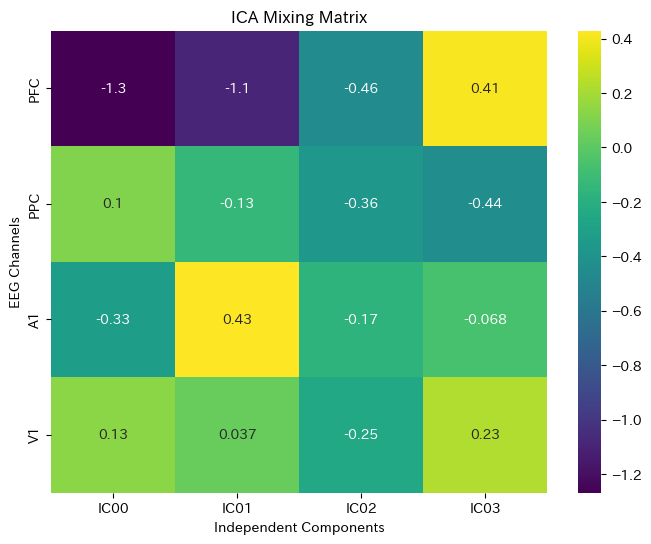

In [27]:
import seaborn as sns
# 混合行列を取得
mixing_matrix = ica.mixing_matrix_

# ヒートマップで可視化
plt.figure(figsize=(8, 6))
sns.heatmap(mixing_matrix, annot=True, cmap='viridis',
            xticklabels=[f'IC{i:02d}' for i in range(ica.n_components_)],
            yticklabels=epochs.ch_names)
plt.title('ICA Mixing Matrix')
plt.xlabel('Independent Components')
plt.ylabel('EEG Channels')
plt.show()

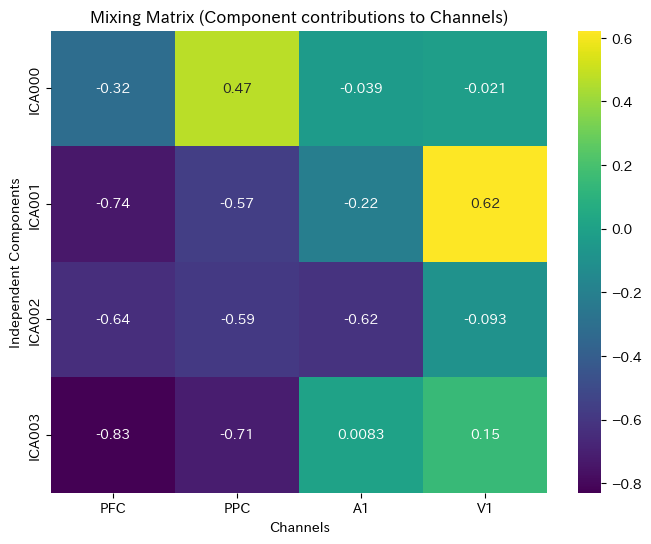

In [44]:
# 混合行列を取得
mixing_matrix = ica.get_components()

# MatplotlibとSeabornでヒートマップをプロット
plt.figure(figsize=(8, 6))
sns.heatmap(
    mixing_matrix,
    annot=True,
    cmap='viridis',
    xticklabels=epochs.ch_names,
    yticklabels=[f'ICA{i:03d}' for i in range(ica.n_components_)]
)
plt.title('Mixing Matrix (Component contributions to Channels)')
plt.xlabel('Channels')
plt.ylabel('Independent Components')
plt.show()

In [47]:
# ica.get_sources()を使って、成分データをEpochsオブジェクトとして取得
component_epochs = ica.get_sources(epochs)

# 各成分のPSDをプロット
# この方法なら `plot_properties` を使わずにPSDを可視化できます
component_epochs.plot_psd(fmin=1, fmax=40, average=True, picks=None)
plt.suptitle('Power Spectral Density of Independent Components', y=1.02)
plt.show()


# 各成分のERP様波形を刺激ごとにプロット
# 例として 'Light' 条件のERP様波形をプロットします
fig, axes = plt.subplots(ica.n_components_, 1, figsize=(8, 2 * ica.n_components_), sharex=True)
if ica.n_components_ == 1: # 成分が1つの場合
    axes = [axes]
for i in range(ica.n_components_):
    component_epochs['Light'].average(picks=i).plot(axes=axes[i], show=False)
    axes[i].set_title(f'ICA{i:03d} - ERP-like activity for "Light"')
    axes[i].set_ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().


ValueError: picks (NoneNone, treated as "data") yielded no channels, consider passing picks explicitly

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().


C:\Users\dmasu\AppData\Local\Temp\ipykernel_24452\4032696067.py:5: RuntimeWarning: The unit for channel(s) ICA000, ICA001, ICA002, ICA003 has changed from NA to V.
  component_epochs.set_channel_types({ch: 'eeg' for ch in component_epochs.ch_names})


    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


c:\Users\dmasu\OneDrive\デスクトップ\pcdh_analyze\venv\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


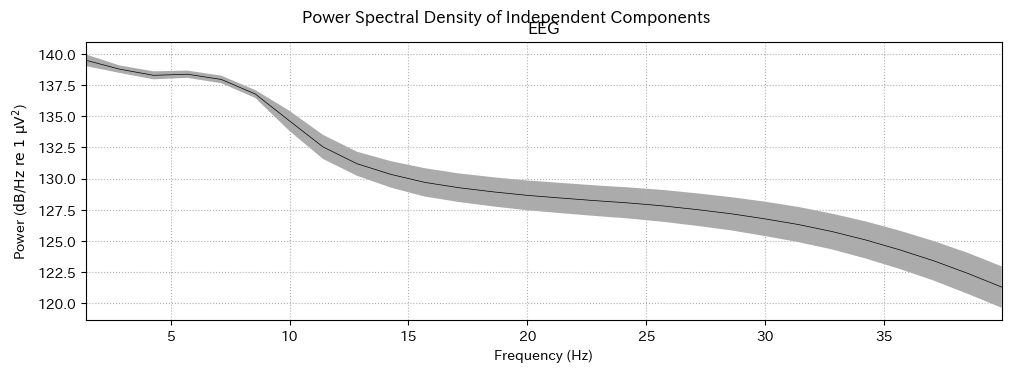

TypeError: picks must be specified (i.e. not None) for ICA channel data

In [35]:
# ica.get_sources()でコンポーネントデータをEpochsオブジェクトとして取得
component_epochs = ica.get_sources(epochs)

# チャネルタイプを'eeg'に設定（PSDプロットに必要）
component_epochs.set_channel_types({ch: 'eeg' for ch in component_epochs.ch_names})

# 各コンポーネントのPSDをプロット
component_epochs.plot_psd(fmin=1, fmax=40, average=True)
plt.suptitle('Power Spectral Density of Independent Components', y=1.02)
plt.show()

# 各コンポーネントのERP様波形をプロット
# ★★★ 修正点 ★★★
# picks引数に、描画したいすべての成分のインデックスを指定します
component_epochs.average().plot(picks=range(ica.n_components_))
# ★★★★★★★★★★★

plt.suptitle('Event-Related Potentials of Independent Components', y=1.02)
plt.show()

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().


C:\Users\dmasu\AppData\Local\Temp\ipykernel_24452\2138514576.py:5: RuntimeWarning: The unit for channel(s) ICA000, ICA001, ICA002, ICA003 has changed from NA to V.
  component_epochs.set_channel_types({ch: 'eeg' for ch in component_epochs.ch_names})


    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


c:\Users\dmasu\OneDrive\デスクトップ\pcdh_analyze\venv\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


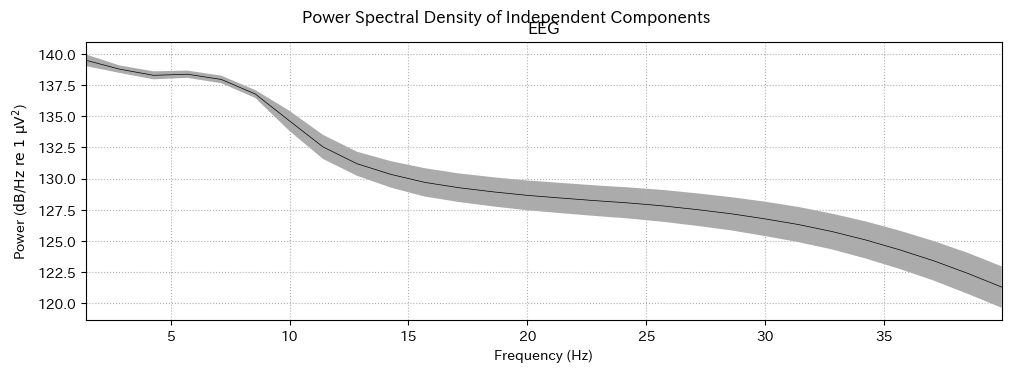

TypeError: picks must be specified (i.e. not None) for ICA channel data

In [ ]:
# ica.get_sources()でコンポーネントデータをEpochsオブジェクトとして取得
component_epochs = ica.get_sources(epochs)

# チャネルタイプを'eeg'に設定します
component_epochs.set_channel_types({ch: 'eeg' for ch in component_epochs.ch_names})


# --- 各コンポーネントのPSDをプロット ---
# こちらも正しく動作していると思いますが、念のため記載します
component_epochs.plot_psd(fmin=1, fmax=40, average=False)
plt.suptitle('Power Spectral Density of Independent Components', y=1.02)
plt.show()


# --- 各コンポーネントのERP様波形をプロット ---
# ★★★ 修正点 ★★★
# spatial_colors=False を指定して、位置情報を使わずにプロットします
component_epochs.average().plot(
    spatial_colors=False,
    show=True # これでプロットがすぐに表示されます
)
# ★★★★★★★★★★★

# タイトルは .plot() の戻り値である Figure オブジェクトに対して設定します
fig = plt.gcf() # 現在のFigureオブジェクトを取得
fig.suptitle('Event-Related Potentials of Independent Components', y=0.98)
plt.show()

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().


C:\Users\dmasu\AppData\Local\Temp\ipykernel_24452\2321876199.py:5: RuntimeWarning: The unit for channel(s) ICA000, ICA001, ICA002, ICA003 has changed from NA to V.
  component_epochs.set_channel_types({ch: 'eeg' for ch in component_epochs.ch_names})


    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


C:\Users\dmasu\AppData\Local\Temp\ipykernel_24452\2321876199.py:10: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  component_epochs.plot_psd(fmin=1, fmax=40)
c:\Users\dmasu\OneDrive\デスクトップ\pcdh_analyze\venv\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


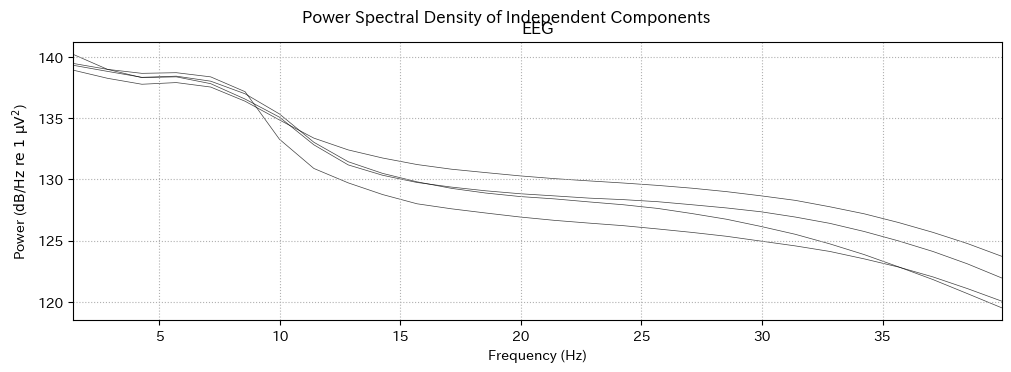

TypeError: picks must be specified (i.e. not None) for ICA channel data

In [38]:
# ica.get_sources()でコンポーネントデータをEpochsオブジェクトとして取得
component_epochs = ica.get_sources(epochs)

# チャネルタイプを'eeg'に設定します
component_epochs.set_channel_types({ch: 'eeg' for ch in component_epochs.ch_names})

# --- 修正点 1 ---
# 各コンポーネントのPSDをプロット
# average=False にすることで、コンポーネントごとに個別のグラフを描画します
component_epochs.plot_psd(fmin=1, fmax=40)
plt.suptitle('Power Spectral Density of Independent Components', y=1.02)
plt.show()

# --- 修正点 2 ---
# 各コンポーネントのERP様波形をプロット
# picks引数で描画したいコンポーネントのインデックスをすべて指定します
component_epochs.average().plot(picks=range(ica.n_components_))
plt.suptitle('Event-Related Potentials of Independent Components', y=1.02)
plt.show()

各コンポーネントのパワースペクトル密度（PSD）をプロット中...
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().


C:\Users\dmasu\AppData\Local\Temp\ipykernel_24452\2335114060.py:5: RuntimeWarning: The unit for channel(s) ICA000, ICA001, ICA002, ICA003 has changed from NA to V.
  component_epochs.set_channel_types({ch: 'eeg' for ch in component_epochs.ch_names})


    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


C:\Users\dmasu\AppData\Local\Temp\ipykernel_24452\2335114060.py:11: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  component_epochs.plot_psd(fmin=1, fmax=40) # average=True を削除
c:\Users\dmasu\OneDrive\デスクトップ\pcdh_analyze\venv\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


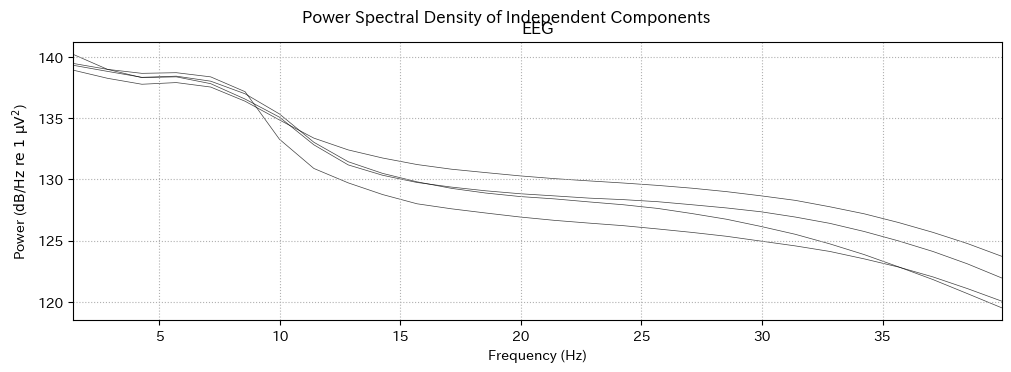

各コンポーネントのERP様波形をプロット中...


TypeError: picks must be specified (i.e. not None) for ICA channel data

In [39]:
# ica.get_sources()でコンポーネントデータをEpochsオブジェクトとして取得
component_epochs = ica.get_sources(epochs)

# チャネルタイプを'eeg'に設定（これはPSDプロットに必要）
component_epochs.set_channel_types({ch: 'eeg' for ch in component_epochs.ch_names})


# --- 修正点 1: PSDプロット ---
# average=True を削除し、コンポーネントごとに個別のPSDグラフを描画
print("各コンポーネントのパワースペクトル密度（PSD）をプロット中...")
component_epochs.plot_psd(fmin=1, fmax=40) # average=True を削除
plt.suptitle('Power Spectral Density of Independent Components', y=1.02)
plt.show()


# --- 修正点 2: ERP様波形プロット ---
# picks='all' を指定して、全てのコンポーネントを描画
print("各コンポーネントのERP様波形をプロット中...")
component_epochs.average().plot(picks='all', titles="Event-Related Potentials of ICs")
plt.show()